In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
np.random.seed(180)
random.seed(180)

#### [Natural Language Processing with Disaster Tweets Dataset](https://www.kaggle.com/competitions/nlp-getting-started/overview)

In [3]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_train["target"].value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

In [6]:
text_id = df_test["id"].tolist()
test_x = df_test["text"].tolist()

In [7]:
df_0 = df_train[df_train["target"] == 0]["text"].tolist()
df_1 = df_train[df_train["target"] == 1]["text"].tolist()

train_x = df_0 + df_1
train_y = [0]*len(df_0) + [1]*len(df_1)

##### **Pre-processing text methods**

1. `process_tweet()`: cleans the text, tokenizes it into separate words, removes stopwords, and converts words to stems.

2. `count_tweets()`: takes a list of tweets as input, `process_tweet()` all of them, and returns a dictionary.
  * The key in the dictionary is a tuple containing the semmed word and its class label, e.g. ("happi",1).
  * The value the number of times this word appears in the given collection of tweets (an integer).

In [8]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yveem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
import re
import string
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

def process_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words("english")
    # remove stock market tickers like $GE
    tweet = re.sub(r"\$\w*", "", tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r"^RT[\s]+", "", tweet)
    # remove hyperlinks
    tweet = re.sub(r"https?:\/\/.*[\r\n]*", "", tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r"#", "", tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and word not in string.punctuation):
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)

    return tweets_clean

def lookup(freqs, word, label):
    n = 0

    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]

    return n

def count_tweets(tweets, ys):
    result = {}
    for y, tweet in zip(ys, tweets):
        for word in process_tweet(tweet):
            pair = (word,y)
            if pair in result:
                result[pair] += 1
            else:
                result[pair] = 1

    return result

In [10]:
process_tweet("""
For those who have been waiting for this scene...

Now, a mass exodus of settlers from northern occupied Palestine have left their homes burning and are fleeing.
""")

['wait',
 'scene',
 '...',
 'mass',
 'exodu',
 'settler',
 'northern',
 'occupi',
 'palestin',
 'left',
 'home',
 'burn',
 'flee']

In [11]:
tweets = ["i am happy", "i am tricked", "i am sad", "i am tired", "i am tired"]
ys = [1, 0, 0, 0, 0]
count_tweets(tweets, ys)

{('happi', 1): 1, ('trick', 0): 1, ('sad', 0): 1, ('tire', 0): 2}

In [12]:
freqs = count_tweets(train_x, train_y)

#### **Logistic Regression**

1. **Sigmoid function**: It maps the input `z` to a value that ranges between 0 and 1, and so it can be treated as a probability.


$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

2. **Cost function and Gradient**: the cost function used for logistic regression is the average of the log loss across all training examples.


$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)}\log(h(z(\theta)^{(i)})) + (1 - y^{(i)})\log(1 - h(z(\theta)^{(i)})) \right]
$$

> $m$ is the number of training examples.

> $y^{(i)}$ is the actual label of the i-th training example.

> $h(z(\theta)^{(i)})$ is the model's prediction for the i-th training example.

3. **Loss function for a single training example**

$$
\text{Loss}(\theta; x, y) = -\left[y^{(i)}\log(h(z(\theta)^{(i)})) + (1 - y^{(i)})\log(1 - h(z(\theta)^{(i)})) \right]
$$

4. **Weight Update**: to update the weight vector, I will apply gradient descent to iteratively improve the model's predictions.

$$
\theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m} \left( h(z(\theta)^{(i)}) - y^{(i)} \right)x_j
$$

In [13]:
def sigmoid(z):
    h = 1 / (1 + np.exp(-z))
    return h

In [14]:
def gradient_descent(x, y, theta, alpha, num_iters):
    m, _ = x.shape
    J_history = []

    for _ in range(num_iters):
        z = np.dot(x, theta)
        h = sigmoid(z)
        J = -1./m * (np.dot(y.transpose(), np.log(h)) + np.dot((1-y).transpose(), np.log(1-h)))
        last_J = float(J.flatten()[0])
        J_history.append(last_J)
        theta = theta - (alpha/m) * np.dot(x.transpose(), (h - y))

    return last_J, J_history, theta

In [15]:
tmp_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)
tmp_Y = (np.random.rand(10, 1) > 0.35).astype(float)

tmp_J, tmp_J_history, tmp_theta = gradient_descent(tmp_X, tmp_Y, np.zeros((3, 1)), 1e-8, 5)
print(f"The cost after training is {tmp_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(tmp_theta)]}")

The cost after training is 0.69189853.
The resulting vector of weights is [np.float64(0.0), np.float64(3.09e-06), np.float64(-8.27e-06)]


In [16]:
import matplotlib.pyplot as plt

def plot_error_history(J_hist):
    plt.plot(range(len(J_hist)), J_hist, label='Error')
    plt.xlabel('Iteration')
    plt.ylabel('Cost J')
    plt.title('Cost Function over Iterations')
    plt.legend()
    plt.show()

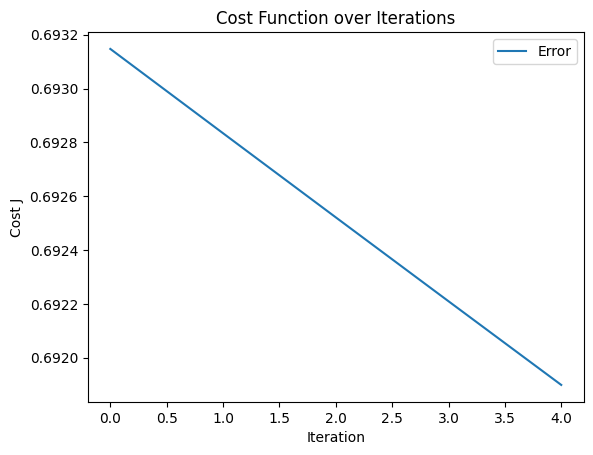

In [17]:
plot_error_history(tmp_J_history)

#### **Features Extractions**

##### Given a list of tweets, let's extract the features and store them into a matrix. I'm gonna extract two features.
  
  * [0] the number of positive for disaster words in a tweet.
  * [1] the number of negative for disaster words in a tweet.

In [18]:
def extract_features(tweet, freqs):
    words = process_tweet(tweet)

    x = np.zeros((1, 3))
    x[0, 0] = 1 # bias

    for word in words:
        x[0, 1] += freqs.get((word, 1.0), 0)
        x[0, 2] += freqs.get((word, 0.0), 0)

    assert(x.shape == (1, 3)), "Invalid feature shape."
    return x

In [19]:
X = np.zeros((len(train_x), 3))
n = len(train_y)
Y = np.array(train_y).reshape((n, 1))

for i in range(len(train_x)):
    X[i, :] = extract_features(train_x[i], freqs)

In [20]:
import optuna
import numpy as np

def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-10, 1e-3, log=True)
    num_iters = trial.suggest_int("num_iters", 100, 5000, step=100)

    initial_theta = np.zeros((3, 1))
    J, _, _ = gradient_descent(X, Y, initial_theta, alpha, num_iters)
    return J

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
best_params = study.best_params
print(f"Best parameters: {best_params}")

c:\Users\yveem\.conda\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-01-05 19:10:34,166] A new study created in memory with name: no-name-7b8519ea-6e40-4624-9887-6c8254aefdef
C:\Users\yveem\AppData\Local\Temp\ipykernel_10020\3338700869.py:8: RuntimeWarning: divide by zero encountered in log
  J = -1./m * (np.dot(y.transpose(), np.log(h)) + np.dot((1-y).transpose(), np.log(1-h)))
[W 2025-01-05 19:10:34,262] Trial 0 failed with parameters: {'alpha': 0.0004058903384422454, 'num_iters': 400} because of the following error: The value nan is not acceptable.
[W 2025-01-05 19:10:34,263] Trial 0 failed with value nan.
[I 2025-01-05 19:10:34,400] Trial 1 finished with value: 0.6926360231772346 and parameters: {'alpha': 5.351127493619601e-10, 'num_iters': 700}. Best is trial 1 with value: 0.6926360231772346

Best parameters: {'alpha': 1.3852582629760839e-05, 'num_iters': 3000}


C:\Users\yveem\AppData\Local\Temp\ipykernel_10020\2987393730.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
C:\Users\yveem\AppData\Local\Temp\ipykernel_10020\2987393730.py:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)
[W 2025-01-05 19:11:51,195] Trial 53 is omitted in visualization because its objective value is inf or nan.


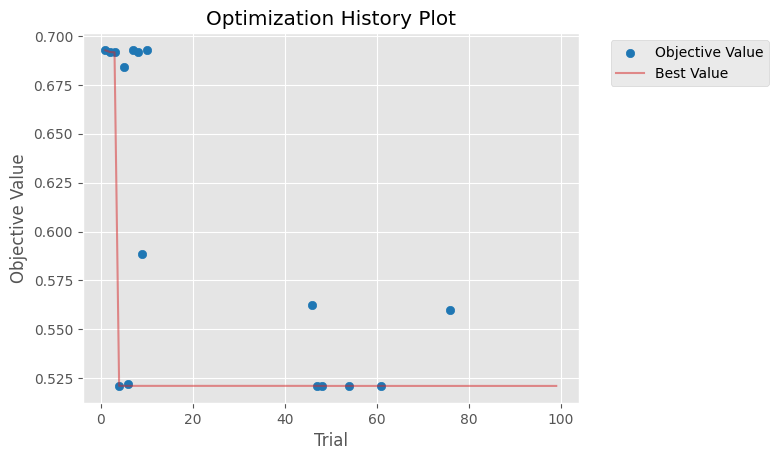

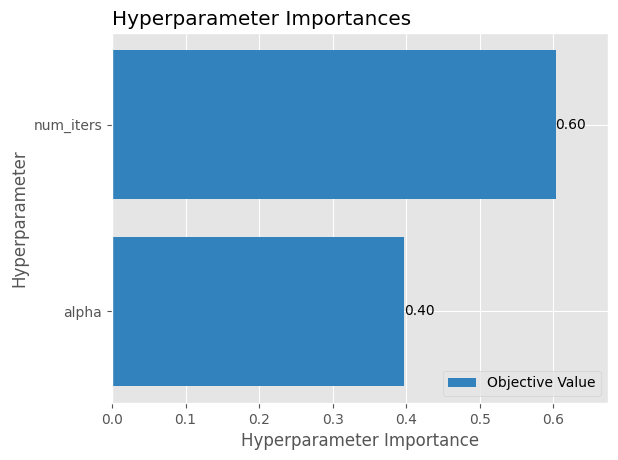

In [21]:
# Plot the optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

In [22]:
J, J_history, theta = gradient_descent(X, Y, np.zeros((3, 1)), best_params["alpha"], best_params["num_iters"])
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.52105918.
The resulting vector of weights is [np.float64(-0.00113689), np.float64(0.0082905), np.float64(-0.00906061)]


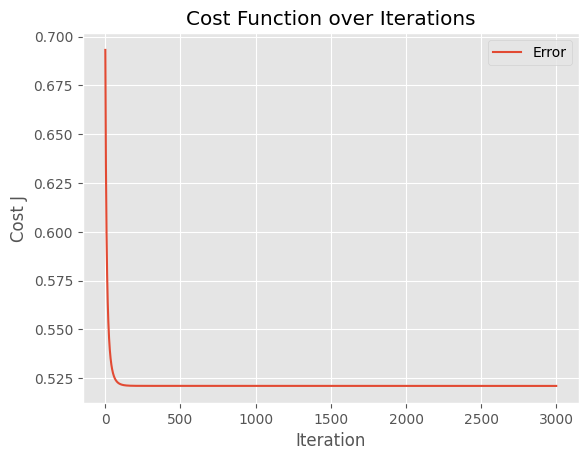

In [23]:
plot_error_history(J_history)

#### **Predictions**

##### Given a tweet, what is the probability of being a disaster description?

In [24]:
def predict_tweet(tweet, freqs, theta):
    x = extract_features(tweet,freqs)
    y_pred = sigmoid(np.dot(x,theta))
    return y_pred

In [25]:
my_tweet = """
For those who have been waiting for this scene...

Now, a mass exodus of settlers from northern occupied Palestine have left their homes burning and are fleeing.
"""
p = predict_tweet(my_tweet, freqs, theta)
print("The expected output is", p)

The expected output is [[0.91823684]]


In [26]:
my_tweet = """
My life is good now that I found you! I'm happy with u.
"""
p = predict_tweet(my_tweet, freqs, theta)
print("The expected output is", p)

The expected output is [[0.08967865]]


In [27]:
preds = []
ids = []
for _, row in df_test.iterrows():
  tweet = row["text"]
  ids.append(row["id"])
  if predict_tweet(tweet, freqs, theta) > 0.5:
    preds.append(1)
  else:
    preds.append(0)

In [28]:
df_submit = pd.DataFrame({"id": ids, "target": preds})

In [29]:
df_submit.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [30]:
df_submit.to_csv("./results/logistic_regression.csv", index=False)